In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.colors as mcolors
from dateutil import parser

# Import Scikit-learn for Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [6]:
df = pd.read_csv('df_arabica_clean.csv', encoding='ISO-8859-1')
#df.to_excel('./coffee.xlsx')
df

,Unnamed: 0,ID,Country of Origin,Farm Name,Lot Number,Mill,ICO Number,Company,Altitude,Region,...,Total Cup Points,Moisture Percentage,Category One Defects,Quakers,Color,Category Two Defects,Expiration,Certification Body,Certification Address,Certification Contact
0,0,0,Colombia,Finca El Paraiso,CQU2022015,Finca El Paraiso,NaN,Coffee Quality Union,1700-1930,"Piendamo,Cauca",...,89.33,11.8,0,0,green,3,"September 21st, 2023",Japan Coffee Exchange,ã413-0002 éå²¡çç±æµ·å¸ä¼è±å±±ï¼ï¼ï...,æ¾æ¾¤ãå®æ¨¹ãKoju Matsuzawa - +81(0)90856...
1,1,1,Taiwan,Royal Bean Geisha Estate,"The 2022 Pacific Rim Coffee Summit,T037",Royal Bean Geisha Estate,NaN,Taiwan Coffee Laboratory,1200,Chiayi,...,87.58,10.5,0,0,blue-green,0,"November 15th, 2023",Taiwan Coffee Laboratory å°ç£åå¡ç ç©¶å®¤,"QAHWAH CO., LTD 4F, No. 225, Sec. 3, Beixin Rd...","Lin, Jen-An Neil æä»å® - 886-289116612"
2,2,2,Laos,OKLAO coffee farms,"The 2022 Pacific Rim Coffee Summit,LA01",oklao coffee processing plant,NaN,Taiwan Coffee Laboratory,1300,Laos Borofen Plateau,...,87.42,10.4,0,0,yellowish,2,"November 15th, 2023",Taiwan Coffee Laboratory å°ç£åå¡ç ç©¶å®¤,"QAHWAH CO., LTD 4F, No. 225, Sec. 3, Beixin Rd...","Lin, Jen-An Neil æä»å® - 886-289116612"
3,3,3,Costa Rica,La Cumbre,CQU2022017,La Montana Tarrazu MIll,NaN,Coffee Quality Union,1900,"Los Santos,Tarrazu",...,87.17,11.8,0,0,green,0,"September 21st, 2023",Japan Coffee Exchange,ã413-0002 éå²¡çç±æµ·å¸ä¼è±å±±ï¼ï¼ï...,æ¾æ¾¤ãå®æ¨¹ãKoju Matsuzawa - +81(0)90856...
4,4,4,Colombia,Finca Santuario,CQU2023002,Finca Santuario,NaN,Coffee Quality Union,1850-2100,"Popayan,Cauca",...,87.08,11.6,0,2,yellow-green,2,"March 5th, 2024",Japan Coffee Exchange,ã413-0002 éå²¡çç±æµ·å¸ä¼è±å±±ï¼ï¼ï...,æ¾æ¾¤ãå®æ¨¹ãKoju Matsuzawa - +81(0)90856...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,202,202,Brazil,Fazenda Conquista,019/22,Dry Mill,NaN,Ipanema Coffees,950,Sul de Minas,...,80.08,11.4,0,0,green,4,"February 2nd, 2024",Brazil Specialty Coffee Association,"Rua Gaspar Batista Paiva, 416 â Santa Luiza ...",Chris Allen - 55 35 3212-4705
203,203,203,Nicaragua,Finca San Felipe,017-053-0155,Beneficio Atlantic SÃ©baco,017-053-0155,Exportadora Atlantic S.A,1200,Matagalpa,...,80.00,10.4,0,2,green,12,"March 2nd, 2024",AsociaciÃ³n de CafÃ©s Especiales de Nicaragua,"Del Hotel Seminole 2 C al lago, 1 C arriba.",Maria Ines Benavidez Toval - 011-(505)-8396 4717
204,204,204,Laos,-,105/3/VL7285-005,DRY MILL,105/3/VL7285-005,Marubeni Corporation,1300,Bolaven Plateau,...,79.67,11.6,0,9,green,11,"November 11th, 2023",Japan Coffee Exchange,ã413-0002 éå²¡çç±æµ·å¸ä¼è±å±±ï¼ï¼ï...,æ¾æ¾¤ãå®æ¨¹ãKoju Matsuzawa - +81(0)90856...
205,205,205,El Salvador,"Rosario de Maria II, Area de La Pila",0423A01,"Optimum Coffee, San Salvador, El Salvador",NaN,Aprentium Enterprises LLC,1200,"Volcan de San Vicente, La Paz, El Salvador",...,78.08,11.0,0,12,bluish-green,13,"March 7th, 2024",Salvadoran Coffee Council,"Final 1a. Av. Norte y 13 Calle Pte., dentro de...",Tomas Bonilla - (503) 2505-6600


Очистка и подготовка данных

In [7]:
# Обработка дубликатов
duplicate_rows_data = df[df.duplicated()]
print("Количество повторяющихся строк: ", duplicate_rows_data.shape)

Количество повторяющихся строк:  (0, 41)


In [8]:
# Проверка уникальности данных в столбцах
print(f"Колонка | Кол-во уникальных значений")
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")


Колонка | Кол-во уникальных значений
Unnamed: 0: 207 distinct values
ID: 207 distinct values
Country of Origin: 22 distinct values
Farm Name: 173 distinct values
Lot Number: 188 distinct values
Mill: 163 distinct values
ICO Number: 68 distinct values
Company: 72 distinct values
Altitude: 98 distinct values
Region: 121 distinct values
Producer: 173 distinct values
Number of Bags: 55 distinct values
Bag Weight: 39 distinct values
In-Country Partner: 21 distinct values
Harvest Year: 7 distinct values
Grading Date: 75 distinct values
Owner: 80 distinct values
Variety: 49 distinct values
Status: 1 distinct values
Processing Method: 11 distinct values
Aroma: 19 distinct values
Flavor: 19 distinct values
Aftertaste: 20 distinct values
Acidity: 19 distinct values
Body: 17 distinct values
Balance: 18 distinct values
Uniformity: 3 distinct values
Clean Cup: 1 distinct values
Sweetness: 1 distinct values
Overall: 21 distinct values
Defects: 1 distinct values
Total Cup Points: 81 distinct values
M

In [9]:
processing_mapping = {
    "Double Anaerobic Washed": "Washed / Wet",
    "Semi Washed": "Washed / Wet",
    "Honey,Mossto": "Pulped natural / honey",
    "Double Carbonic Maceration / Natural": "Natural / Dry",
    "Wet Hulling": "Washed / Wet",
    "Anaerobico 1000h": "Washed / Wet",
    "SEMI-LAVADO": "Natural / Dry"
}

df['Processing Method'] = df['Processing Method'].map(processing_mapping)
df['Processing Method'].fillna("Washed / Wet", inplace=True)

In [10]:
# Установить корректный год урожая
df['Harvest Year'] = df['Harvest Year'].str.split('/').str[0].str.strip()

In [11]:
# Изменить тип "Harvest Year" and "Expiration" на datetime
df['Harvest Year'] = pd.to_datetime(df['Harvest Year'], format='%Y')
df['Expiration'] = df['Expiration'].apply(parser.parse)

In [12]:
# Рассчитать возраст в днях (между "Срок годности" и "Год сбора урожая")
df['Coffee Age'] = (df['Expiration'] - df['Harvest Year']).dt.days

In [13]:
# Анализ и дроп столбцов, которые не участвуют
columns_to_drop = ['ID', 'ICO Number', 'Owner', 'Region',
                   'Certification Contact', 'Certification Address',
                   'Farm Name', "Lot Number", "Mill", "ICO Number",
                   "Producer", 'Company', 'Expiration', 'Harvest Year',
                   "Unnamed: 0", 'Number of Bags', 'Bag Weight',
                   'In-Country Partner', 'Grading Date', 'Variety',
                   'Status', 'Defects', 'Uniformity', 'Clean Cup',
                   'Sweetness', 'Certification Body']
df.drop(columns_to_drop, axis=1, inplace=True)

In [14]:
print(df.isnull().sum())
data = df.dropna()
print(data.isnull().sum())
# сейв
# data.to_csv('очищенные_данные.csv', index=False)

Country of Origin       0
Altitude                1
Processing Method       0
Aroma                   0
Flavor                  0
Aftertaste              0
Acidity                 0
Body                    0
Balance                 0
Overall                 0
Total Cup Points        0
Moisture Percentage     0
Category One Defects    0
Quakers                 0
Color                   0
Category Two Defects    0
Coffee Age              0
dtype: int64
Country of Origin       0
Altitude                0
Processing Method       0
Aroma                   0
Flavor                  0
Aftertaste              0
Acidity                 0
Body                    0
Balance                 0
Overall                 0
Total Cup Points        0
Moisture Percentage     0
Category One Defects    0
Quakers                 0
Color                   0
Category Two Defects    0
Coffee Age              0
dtype: int64


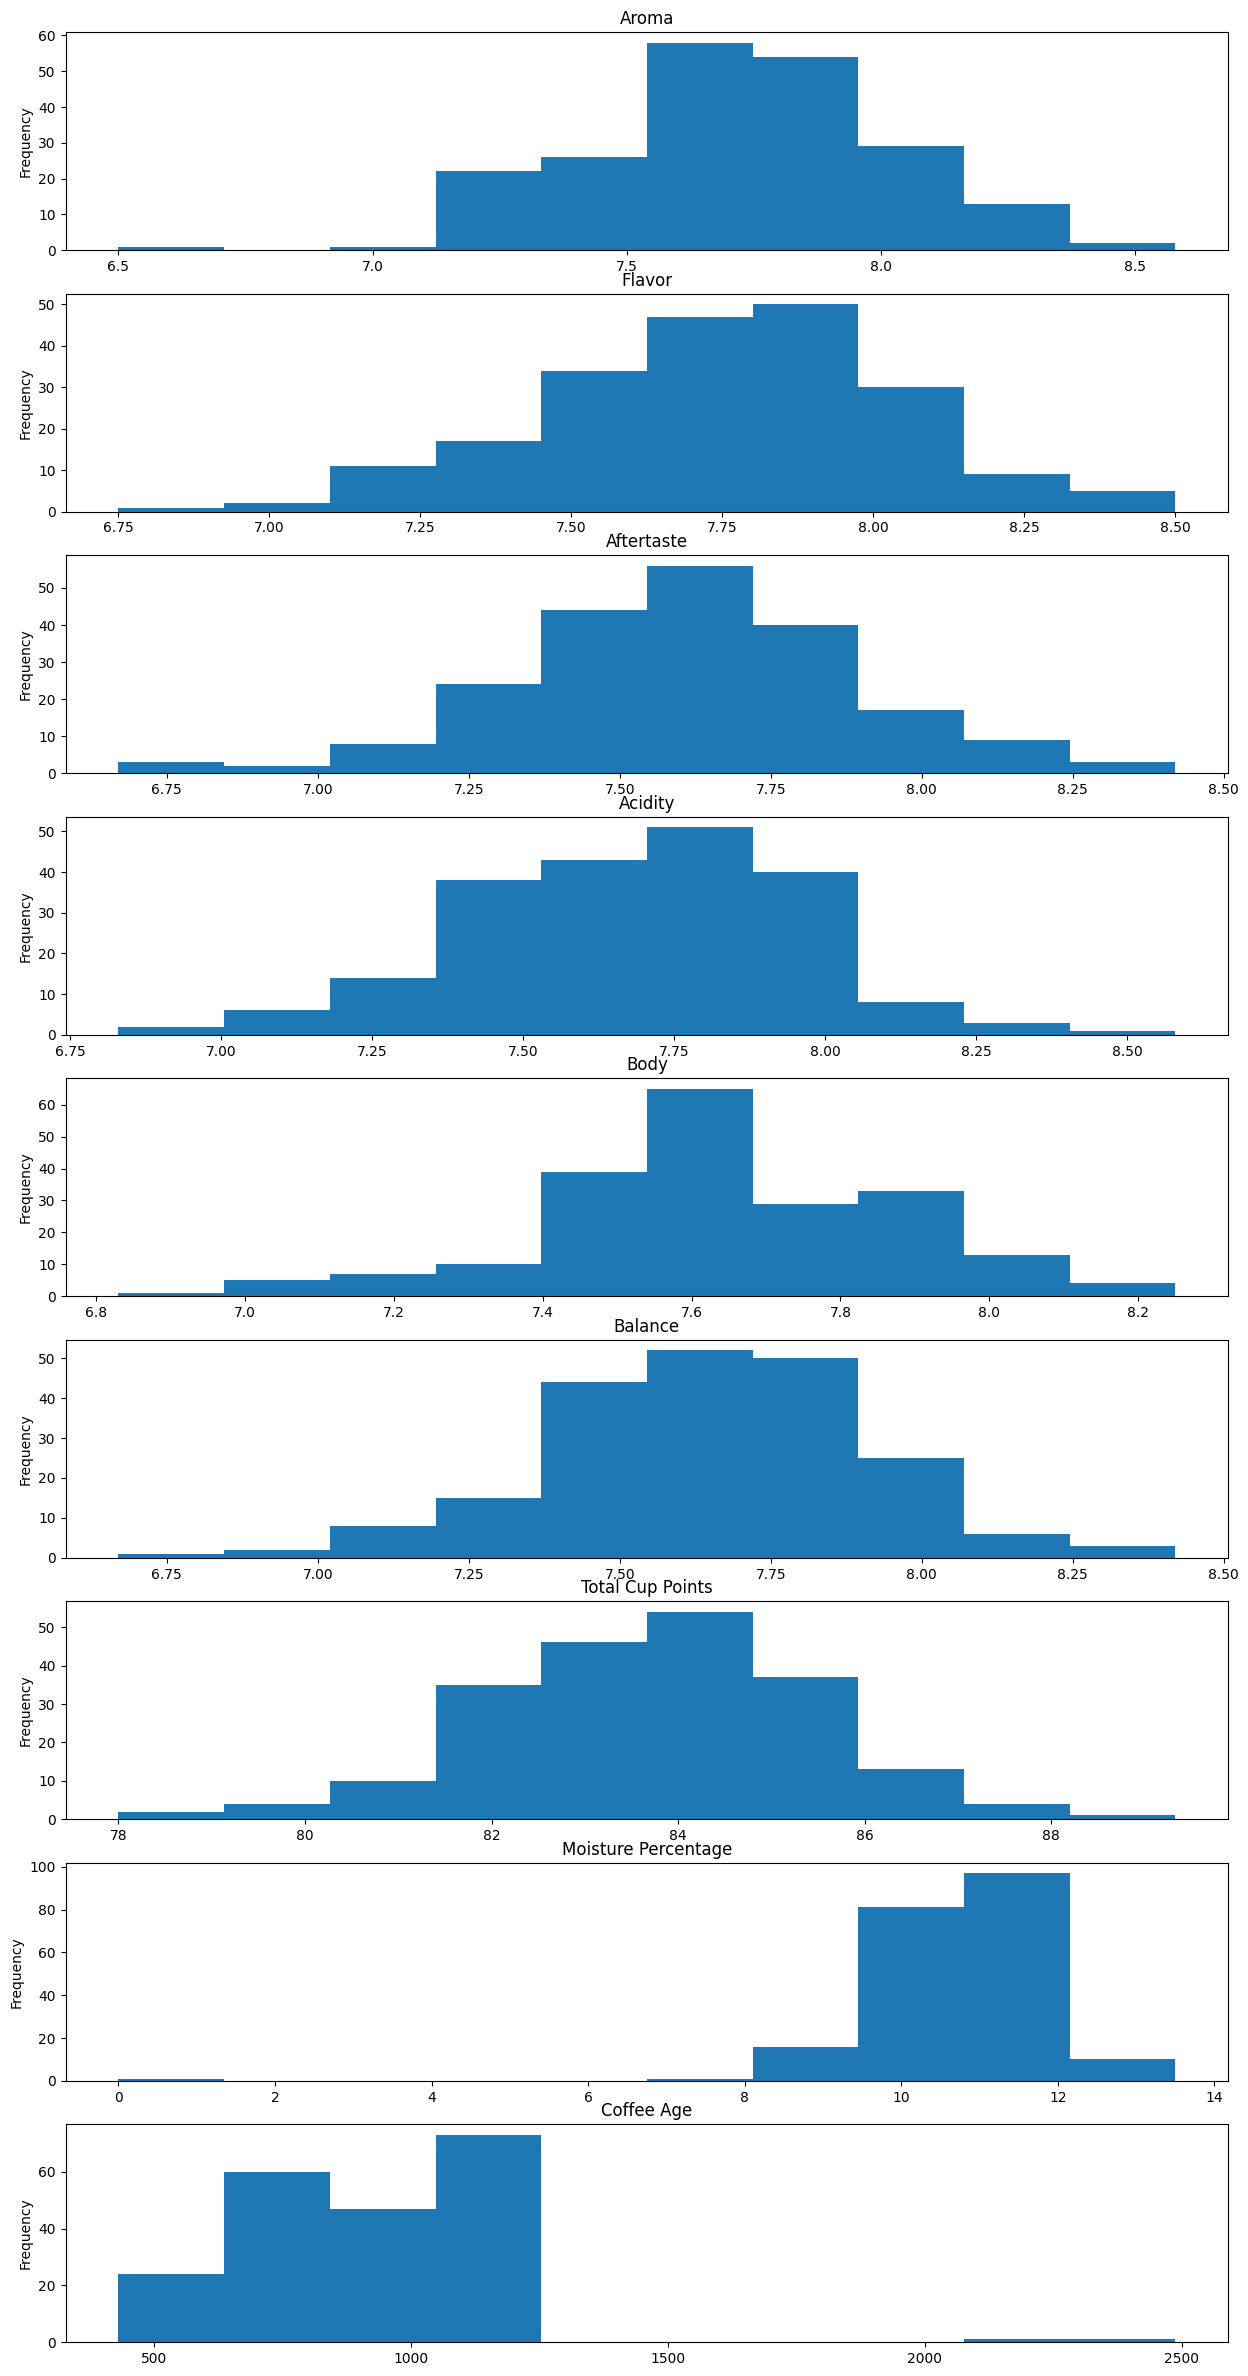

In [15]:
fig, axs = plt.subplots(9, 1, figsize=(15, 30))

#'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Total Cup Points', 'Moisture Percentage','Coffee Age'
data['Aroma'].plot(kind='hist', ax=axs[0],  title='Aroma')
data['Flavor'].plot(kind='hist', ax=axs[1], title='Flavor')
data['Aftertaste'].plot(kind='hist', ax=axs[2], title='Aftertaste')
data['Acidity'].plot(kind='hist', ax=axs[3],  title='Acidity')
data['Body'].plot(kind='hist', ax=axs[4], title='Body')
data['Balance'].plot(kind='hist', ax=axs[5], title='Balance')
data['Total Cup Points'].plot(kind='hist', ax=axs[6], title='Total Cup Points')
data['Moisture Percentage'].plot(kind='hist', ax=axs[7], title='Moisture Percentage')
data['Coffee Age'].plot(kind='hist', ax=axs[8], title='Coffee Age')

plt.show()

<ipython-input-16-eb4f5e0ec4ab>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean = data.drop(columns_to_drop, axis=1, inplace=True)


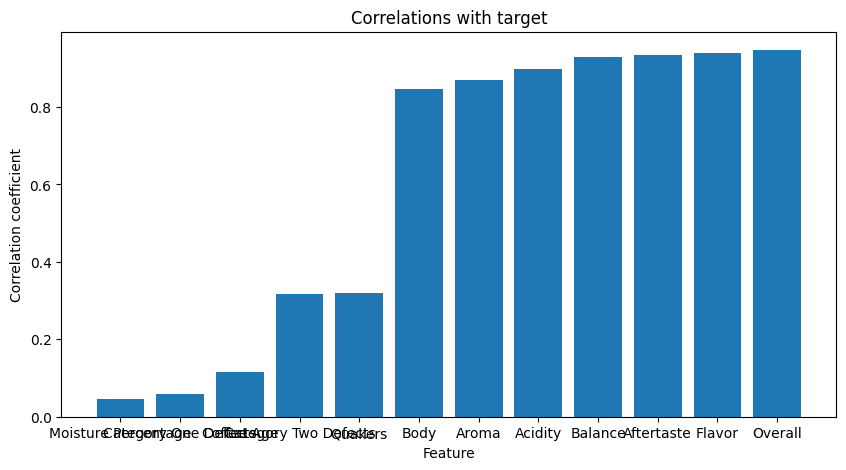

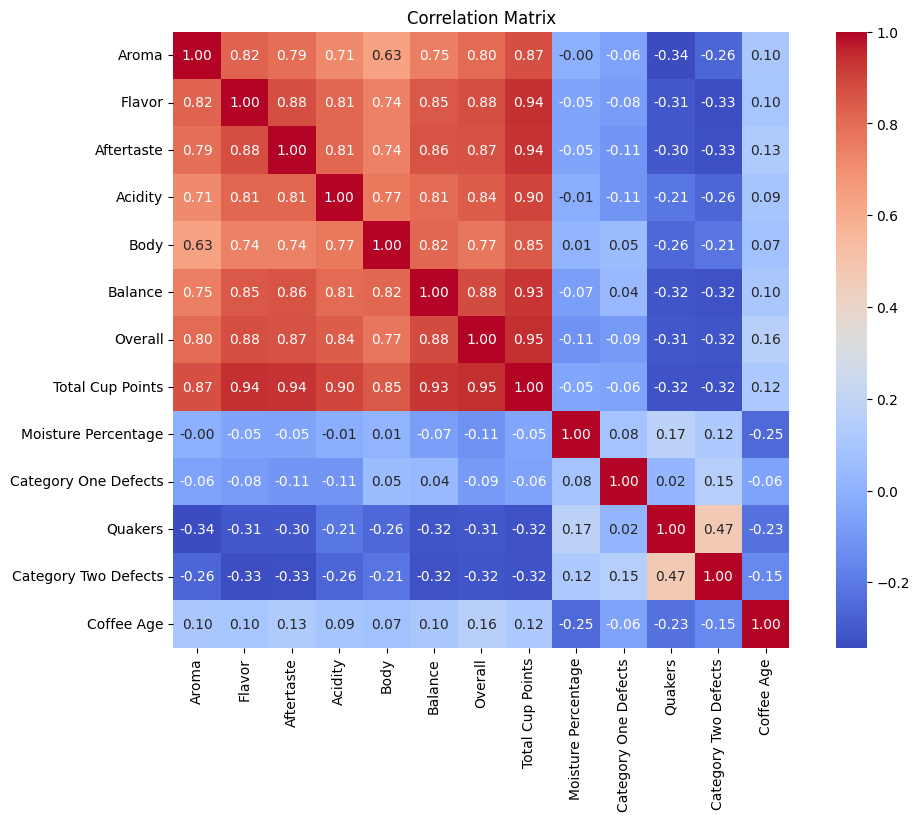

In [16]:
columns_to_drop = ['Country of Origin', 'Processing Method',
                   'Altitude', 'Color']

df_clean = data.drop(columns_to_drop, axis=1, inplace=True)

corr_with_target = data.corr()['Total Cup Points'].abs().sort_values()

corr_with_target = corr_with_target.drop('Total Cup Points')

#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(corr_with_target.index, corr_with_target.values)
ax.set_title('Correlations with target')
ax.set_xlabel('Feature')
ax.set_ylabel('Сorrelation coefficient');

correlation_matrix = data.corr()

# Построение тепловой карты корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

# Корреляционный анализ
Интерпретация результата:

1/ Параметры Aroma (аромат), Flavor (вкус), Aftertaste (послевкусие), Acidity (кислотность), Body (плотность), Balance (баланс) имеют высокое положительное значение коэффициента корреляции Пирсона с значенияем Total Cup Points (от 0.63 до 0.94).

2/ Параметры Moisture Percentage (процент влажности), Category One Defects (дефекты первой категории) имеют слабое отрицательное значение коэффициента корреляции Пирсона с значением Total Cup Points (от -0.06 до -0.05).

3/ Параметры Quakers (квакеры), Category Two Defects (дефекты второй категории) имеют среднее отрицательное значение коэффициента корреляции Пирсона с значенияем Total Cup Points (-0.32).

4/ Параметр Coffee Age (возраст кофе в днях) имеет слабое положительное значение коэффициента корреляции Пирсона с значением Total Cup Points (0.12).

In [17]:
# Деление данных на обучающую и тестовую выборки
x = data.drop('Total Cup Points', axis=1)
y = data['Total Cup Points']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [18]:
# Создаем регрессор
rfr = RandomForestRegressor(n_estimators=150, random_state=42)
rfr.fit(x_train, y_train)  # обучение

# предсказание на тесте
y_pred = rfr.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('R^2 Score:', r2)

Mean Absolute Error: 0.21690634920634316
Mean Squared Error: 0.10782418952380696
R^2 Score: 0.9537445294822842


# Метрики обучения модели (ошибок)

Интерпретация результатов:

1/ Mean Absolute Error (MAE): 0.2169

Этот показатель показывает среднюю абсолютную ошибку между предсказанными и реальными значениями. Значение MAE около 0.22 может указывать на то, что в среднем предсказания отклоняются от реальных значений на 0.22 единицы. Это довольно низкое значение, что говорит о том, что модель делает точные предсказания.

2/ Mean Squared Error (MSE): 0.1078
   
MSE измеряет среднюю квадратичную ошибку между предсказаниями и реальными значениями. Поскольку MSE учитывает квадраты ошибок, он более чувствителен к большим ошибкам. Значение 0.1078 также указывает на хорошее качество модели.

3/ R² Score: 0.9537

Коэффициент детерминации показывает долю вариации зависимой переменной, объясняемую моделью. Значение R² близкое к 1 говорит о том, что модель объясняет около 95.37% вариации в данных. Это очень высокий показатель, который свидетельствует о том, что модель хорошо подходит обучения этих данных.

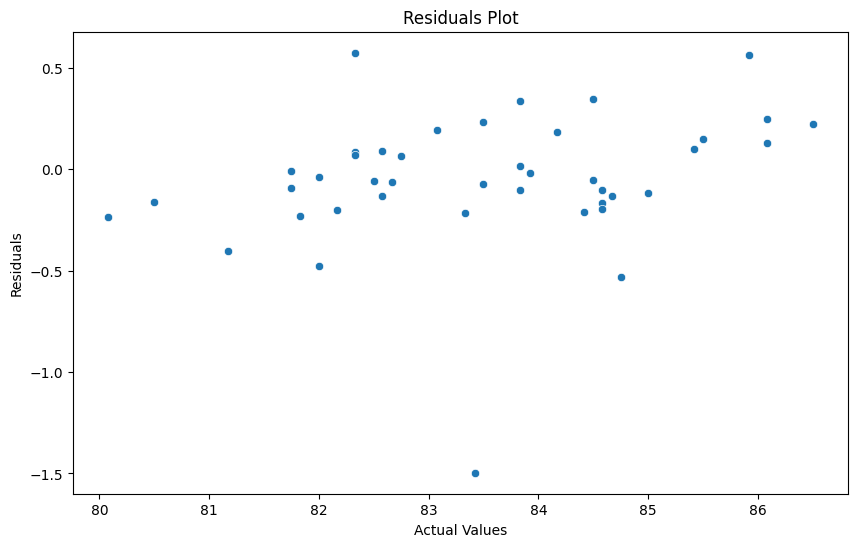

In [19]:
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
sns.scatterplot(x=y_test, y=residuals)
plt.title('Residuals Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

# Остаточный анализ

Интерпретация результата:

1/ На графике этого типа мы можем наглядно представить расхождение между фактическими значениями и прогнозируемыми значениями в регрессионной модели.
В оси X отложены реальные значения параметра Total Cup Points, а на оси Y располагается разница между реальными и прогнозируемыми значениями.

---
**Остаточный анализ = реальное значение - прогнозируемое значение**

e = y - ŷ

---

При идельных условиях, все точки остаточного анализа должны располагаться вдоль горизонтальной линии при y=0.

Изучая график, можно заметить, что остатки распределены вокруг линии y=0, что свидетельствует о положительном результате. Также позволяет сделать вывод, что ошибки модели разбросаны случайным образом и не имеют какую-либо заметную закономерность.

Тем не менее, существуют определенные точки (больше 0.25, меньше -0.25), которые отклоняются от линии y=0, указывая на области, где прогнозы модели были неточными. Точки, расположенные далеко от линии, указывают на прогнозы, которые существенно отличаются от реальных значений.

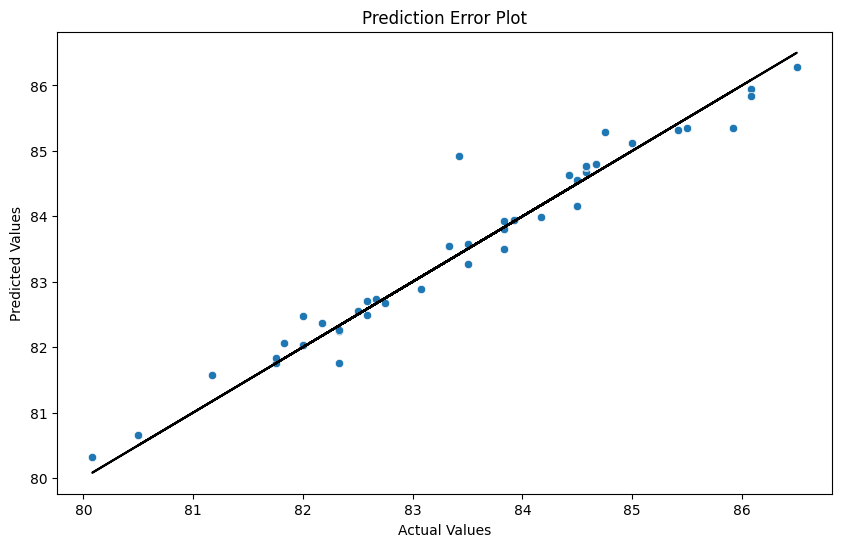

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Prediction Error Plot')
plt.plot(y_test, y_test, color='black')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Ошибки прогнозирования регрессионной модели

Интерпретация результата:

1/ На графике этого типа мы можем изучить различия между реальными и прогнозируемыми значениями в регрессионной модели.
В оси X отложены реальные значения параметра Total Cup Points, а на оси Y располагаются прогнозируемые значения.

В идеальных условиях, все точки должны были бы выровнены по диагональной линии. Эта линия представляет случаи, когда прогнозируемое значение точно совпадает с фактическим значением.

Большинство точек расположены близко к диагональной линии, что указывает на достаточно точные прогнозы модели. Однако, на графике можно заметить определенные точки, которые отклоняются от линии. Точка, расположенная далеко от линии, указывает на прогноз, значительно отличающийся от реальных значений.

Кроме того, плотность точек может дать представление о распределении ошибок. На графике отсутствует высокую плотность точек вдали от диагональной линии, это указывает на отсутствие систематических ошибок в модели.